In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from IPython import display
import time
from torch.utils.data import DataLoader, Dataset

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [5]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)
np.max(test_data)

Test data shape:  (4, 320, 256, 256)


np.float32(1.0)

In [6]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [7]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('unconditional_models/fixed_output_trained_model_epoch400.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [34]:
def denoise(x_t, mask, y, model, step_size, beta_min = 1e-4, beta_max = 0.02, steps=1000):
    betas = torch.linspace(beta_min, beta_max, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    for t in reversed(range(steps)):
        alpha_t_bar = alphas_cumprod[t]
        alpha_t_bar_prev =  alphas_cumprod[t-1]
        beta_t = betas[t]
        alpha_t = alphas[t]

        # Predict the noise using the model
        #with torch.no_grad():
        epsilon_theta = model(x_t)
    
        score_unconditional = -epsilon_theta/torch.sqrt(1-alpha_t_bar)
        x0_hat = 1/torch.sqrt(alpha_t_bar) * (x_t + (1-alpha_t_bar) * score_unconditional)

        if t > 0:
            A = mask * x0_hat
            difference = y - A
            loss = torch.linalg.norm(difference)
            likelihood_grad = torch.autograd.grad(loss, x_t)[0]
            mean =  (torch.sqrt(alpha_t) * (1-alpha_t_bar_prev))/(1 - alpha_t_bar) * x_t + (torch.sqrt(alpha_t_bar_prev) * beta_t)/(1 - alpha_t_bar) * x0_hat
            
            z = torch.randn_like(x_t).to(device)
            x_t = mean + torch.sqrt(beta_t) * z
            x_t -= step_size * likelihood_grad  

    return x0_hat



In [25]:
def denoise_dataloader(mask, y_dataloader, model, step_size, beta_min = 1e-4, beta_max = 0.02, steps=1000):
    images = []
    for i, y in enumerate(y_dataloader):
        print(i)
        x_t = torch.randn_like(y, requires_grad=True, dtype=torch.float32).to(device)
        y = y.detach().clone().to(device)
        generated_image = denoise(x_t, mask, y, model, step_size).reshape(-1,256,256).detach().cpu().numpy()
        images.append(generated_image)
    images = np.concatenate(images, axis=0)
    return images

In [10]:
class NumpyDataset(Dataset):
    def __init__(self, data):
        # Reshape the data to create individual samples
        self.data = data.reshape(-1, 256, 256)
        # Normalize the data to [-1, 1]
        #self.data = 2 * (self.data - np.min(self.data)) / (np.max(self.data) - np.min(self.data)) - 1
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        return torch.tensor(image, dtype=torch.float32)

In [65]:
#Randomly choose a fixed percentage of points from the test snapshot
trajectory = 3
percentage = 10
factor = percentage/100
start_idx = 85
end_idx = 86
N = int(256**2 * factor)
test_snapshots = test_data[:, start_idx : end_idx]

#nx = np.random.randint(0, 256, (N,))
#ny = np.random.randint(0, 256, (N,))
nx = 50 * np.ones_like(128).astype(np.int16)
ny = np.arange(0,256,2)

sparse_measurement =  test_snapshots[..., nx, ny]
plot_idx = 0
mask = np.zeros_like(test_snapshots[trajectory])
mask[..., nx, ny] = 1
print(np.sum(mask))
y = test_snapshots[trajectory] * mask
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
#ax.scatter(xx*mask, yy*mask, s=1, c="black", alpha=0.5)

measurement_std = 0.0
measurement_noise = np.random.randn(*mask.shape) * measurement_std
y = y + measurement_noise * mask
y_dataset = NumpyDataset(y)
y_dataloader = DataLoader(y_dataset, batch_size=32, shuffle=False)

mask = torch.tensor(mask, requires_grad=True).to(device)
epsilon = torch.randn_like(mask, requires_grad=True, dtype=torch.float32).unsqueeze(1).to(device)

step_size= 1.0
generated_sample = denoise_dataloader(mask, y_dataloader, model, step_size)



128.0
0


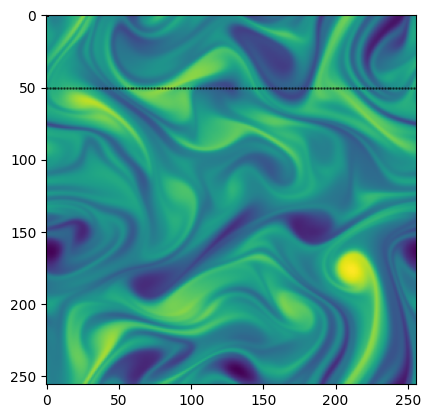

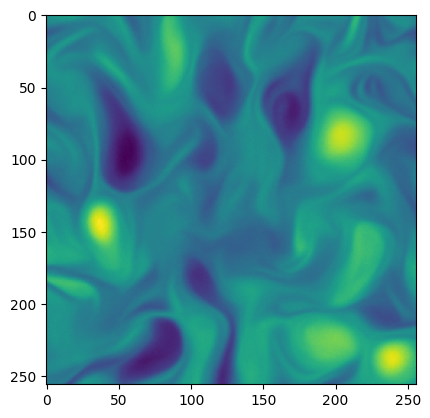

In [66]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
ax.imshow(test_snapshots[trajectory, plot_idx].squeeze())
ax.scatter(xx*mask.detach().cpu().numpy(), yy*mask.detach().cpu().numpy(), s=1, c="black", alpha=0.5)
ax2.imshow(generated_sample[plot_idx])

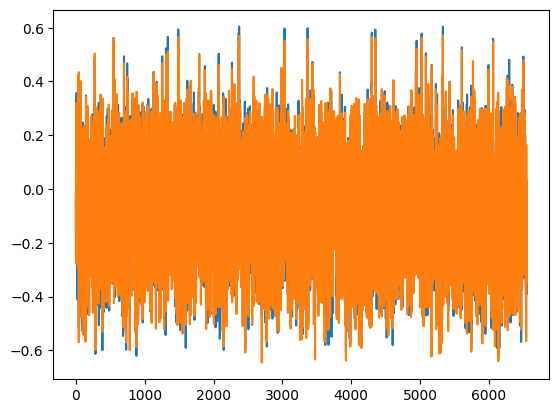

In [230]:
plt.plot(generated_sample[plot_idx, nx,ny])
plt.plot(test_snapshots[trajectory, plot_idx, nx,ny])

In [14]:
def two_point_corr(field, axis=0):
    number_of_cells = field.shape[axis]
    mean = np.mean(field)
    field_prime = field - mean
    var = np.var(field)
    f_corr = []
    for ii in range(number_of_cells // 2):
        f_corr_ii = np.mean(field_prime * np.roll(field_prime, shift=ii, axis=axis)) / var # longitudinal
        f_corr.append(f_corr_ii)
    f_corr = np.array(f_corr)
    return f_corr

In [108]:
if step_size == 0:
    name = "unconditional" 
else:
    name = "step_size_" + str(step_size) + "_" + "p" + "_" + str(percentage)
name = "generated_samples/" + name + ".npy"
np.save(name, generated_sample)


194665 unconditional.npy
14537 step_size_1.0_p_0.1.npy
10 step_size_1.0_p_1.0.npy
17 step_size_1.0_p_10.npy


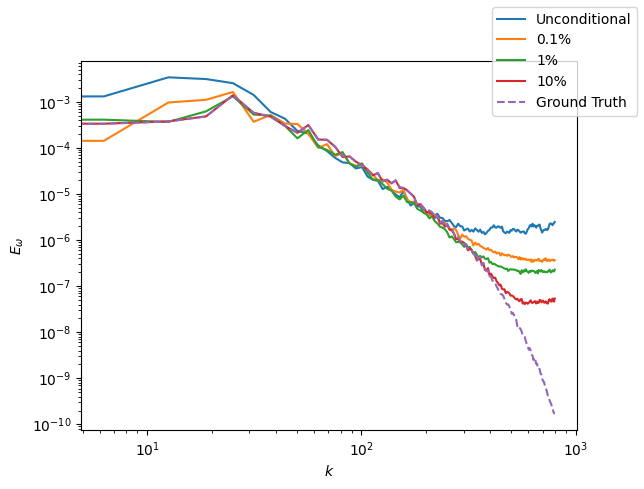

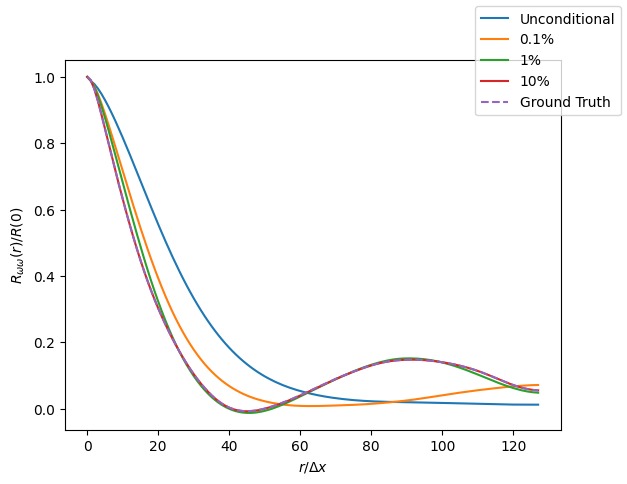

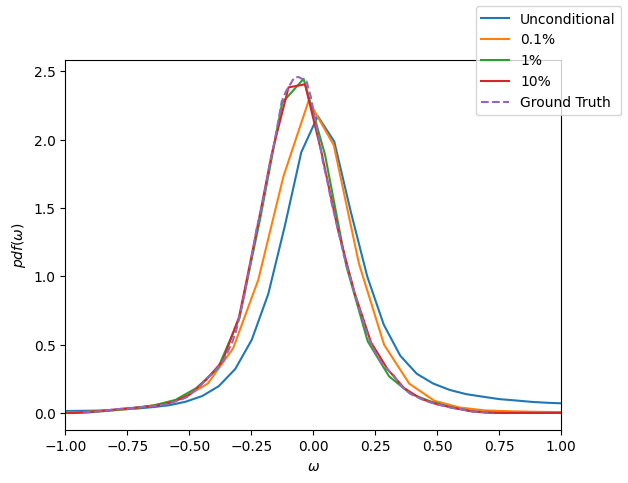

In [141]:
from energy_spectrum import compute_tke_spectrum
import os
def denormalize(data, min, max):
    return min + (1 + data) * (max - min)/2

fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()

#data = np.load("/home/baris/Documents/DDSim/Diffusion-based-Fluid-Super-resolution/data/kf_2d_re1000_256_40seed.npy")
#train_data = data[:-4]
#test_data = data[-4:]
#minimum_train, maximum_train = np.min(train_data), np.max(train_data)

names = os.listdir("generated_samples")
names = [names[0]] + names[:0:-1]

two_point_corrs = []
spectra = []
pdfs = []
bins_list = []
for name in names:
    generated_sample_numpy = np.load("generated_samples/" + name)
    print(np.sum(np.abs(generated_sample_numpy) > 1), name)
    test_snapshots_100 = np.load("test_snapshots_100.npy")
    #generated_sample_numpy = denormalize(generated_sample_numpy)
    _, wavenumbers, spectrum = compute_tke_spectrum(generated_sample_numpy[plot_idx],1,1)
    pdf, bins = np.histogram(generated_sample_numpy.flatten(), bins=100, density=True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    two_point_correlation = two_point_corr(generated_sample_numpy, axis=1)
    spectra.append(spectrum)
    two_point_corrs.append(two_point_correlation)
    pdfs.append(pdf)
    bins_list.append(bins)

spectra = np.array(spectra)
two_point_corrs = np.array(two_point_corrs)
bins = np.array(bins_list)
pdfs = np.array(pdfs)

_, wavenumbers, spectrum_ground_truth = compute_tke_spectrum(test_snapshots_100[plot_idx],1,1)
two_point_correlation_gt = two_point_corr(test_snapshots_100, axis=1)
pdf_ground_truth, bins_gt = np.histogram(test_snapshots_100.flatten(), bins=100, density=True)
bins = bins.T
dx = (np.max(test_snapshots_100) - np.min(test_snapshots_100))/100
dx_generated = bins[1:] - bins[:-1]

ax.plot(wavenumbers[:128], spectra.T[:128])
ax.plot(wavenumbers[:128], spectrum_ground_truth[:128], "--")
ax2.plot(two_point_corrs.T)
ax2.plot(two_point_correlation_gt, "--")
ax3.plot((bins[1:] + bins[:-1])/2, pdfs.T)

ax3.plot((bins_gt[1:] + bins_gt[:-1])/2, pdf_ground_truth, "--")
#ax3.set_ylim([1e-2, 2.55])
ax3.set_xlim([-1,1])


fig.legend(["Unconditional", "0.1%", "1%", "10%", "Ground Truth"])
fig2.legend(["Unconditional", "0.1%", "1%", "10%", "Ground Truth"])
fig3.legend(["Unconditional", "0.1%", "1%", "10%", "Ground Truth"])

ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E_{\omega}$")
ax2.set_xlabel(r"$r/\Delta x$")
ax2.set_ylabel(r"$R_{\omega\omega}(r)/R(0)$")
ax3.set_xlabel(r"$\omega$")
ax3.set_ylabel(r"$pdf(\omega)$")

fig.savefig("plots/dps/dps_spectrum.png", dpi=400)
fig2.savefig("plots/dps/dps_correlation.png", dpi=400)
fig3.savefig("plots/dps/dps_pdf.png", dpi=400)



In [60]:
ensemble_size = 100
ensemble_list = []

epsilon = torch.randn_like(mask, requires_grad=True, dtype=torch.float32).unsqueeze(0).to(device)

print(y.shape)
step_size= 1.0
measurement_std = 0.05

for i in range(ensemble_size):
    print(i)
    measurement_noise = torch.randn_like(mask, dtype=torch.float32) * measurement_std
    y = torch.tensor(y, dtype=torch.float32).to(device) + measurement_noise * mask
    generated_sample = denoise(epsilon, mask, y, model, step_size).squeeze().detach().cpu().numpy()
    ensemble_list.append(generated_sample[..., nx, ny])
ensemble = np.stack(ensemble_list)
ensemble_variance = np.var(ensemble, axis=0)
print(ensemble_variance)



(1, 256, 256)
0
1


/tmp/ipykernel_126021/2072088493.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).to(device) + measurement_noise * mask


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[0.01244434 0.03460504 0.01017213 0.05869085 0.02658268 0.02175524
 0.02107835 0.11121457 0.04844667 0.01187865 0.02287481 0.00820017
 0.01428623 0.01212525 0.02154515 0.01606971 0.01744598 0.01830592
 0.00773088 0.01965585 0.02021649 0.02461482 0.04347616 0.02341565
 0.01318982 0.00611405 0.01294433 0.02098266 0.03314339 0.02848588
 0.04842025 0.07234773 0.02150194 0.01105852 0.0105742  0.01244042
 0.00882928 0.00926426 0.02281828 0.01245847 0.00719977 0.03268939
 0.02023259 0.0131762  0.01509615 0.01887695 0.02129139 0.01883023
 0.03073649 0.01861259 0.02494177 0.02405904 0.02066555 0.01660738
 0.02154338 0.02261561 0.00818333 0.01423255 0.00714967 0.01290841
 0.01178799 0.00536683 0.00744062 0.01030408

(100, 128)


np.float32(0.020025667)

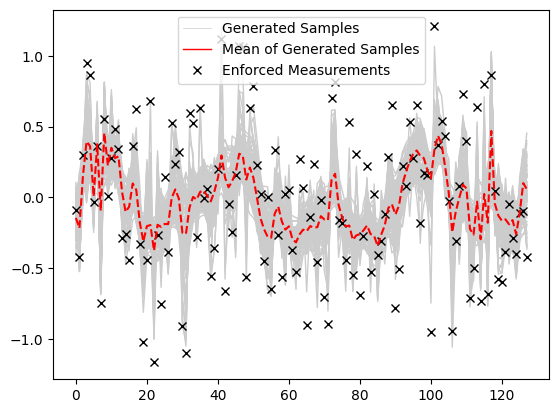

In [61]:
from matplotlib.lines import Line2D
y_numpy = y.detach().cpu().numpy()
ensemble_mean = np.mean(ensemble, axis=0)
print(ensemble.shape)
plt.plot(ensemble.T,  color="0.8", linewidth=1)
plt.plot(y_numpy[...,nx,ny].squeeze(), "x", color="k", linestyle="None")
plt.plot(ensemble_mean, "r", linestyle="--")
gray_lines = Line2D([0], [0], color='0.8', linewidth=0.5)
black_lines = Line2D([0], [0], color='k', linewidth=1, marker="x", linestyle="None")
red_lines = Line2D([0], [0], color='r', linewidth=1)
plt.legend([gray_lines, red_lines, black_lines], ["Generated Samples", "Mean of Generated Samples", "Enforced Measurements"])
plt.savefig("plots/dps/ensemble.png", dpi=400)
np.mean(ensemble_variance)

In [63]:
print(np.mean(ensemble_variance))

0.020025667
